In [191]:
##########################
# CS 430 Final Project
# Emily Warman, Rachael Affenit
# Greedy Approach
##########################

import os
import copy
import itertools
import matplotlib.pyplot as plt
import math

In [192]:
##########################
# Helper Functions
##########################

#define plot function
%matplotlib inline
def plot(points,graph,x_lines,y_lines):
    plt.scatter(*zip(*points))
    axes = plt.gca()
    #plot lines drawn
    for line in x_lines:
        plt.plot([line, line],[0,6], color='b', linestyle='-',linewidth=2)
    for line in y_lines:
        plt.plot([0,6],[line,line], color='b', linestyle='-', linewidth=2)
    #plot remaining
    for point in graph.keys():
        for p2 in graph[point]:
            plt.plot([point[0], p2[0]], [point[1], p2[1]], linestyle='-', linewidth=2)
    plt.show()

#get all permutations of a list of possible lines
def get_permutations(lines):
    return itertools.permutations(lines)

#make a list of possible lines (range function that takes floats)
def drange(x, y, jump):
    r=[]
    while x < y:
        r.append(float(x))
        x += jump
    return r

#create lists of possible points (min x to max x, min y to max y)
def get_all_possible(points):
    x_sort = sorted(points, key=lambda x: x[0])
    y_sort = sorted(points, key=lambda x: x[1])
    x_min = x_sort[0][0]
    x_max = x_sort[-1][0]
    y_min = y_sort[0][1]
    y_max = y_sort[-1][1]
    
    return (drange(x_min+.5,x_max+.5,1), drange(y_min+.5,y_max+.5,1))

#make a graph of all possible graph points
def make_graph(points):
    initial_graph = dict.fromkeys(points)
    for point in initial_graph.keys():
        c_copy = copy.copy(points)
        c_copy.remove(point)
        initial_graph[point] = c_copy
    return initial_graph

#find how many points are separated by a given line
def separate(gg, line, idx):
    left = []
    right = []
    separated = 0
    
    #mark points left and right (or above and below) the line to be drawn
    for point in gg.keys():
        if point[idx] < line:
            left.append(point)
        if point[idx] > line:
            right.append(point)
    #separate the points
    for point in gg.keys():
        if point in left:
            for p2 in right:
                if p2 in gg[point]:
                    separated += 1
        if point in right:
            for p2 in left:
                if p2 in gg[point]:
                    separated += 1
    return separated

#draw a new parallel line to separate points
def draw(gg, line, idx):
    left = []
    right = []
    separated = 0
    
    #mark points left and right (or above and below) the line to be drawn
    for point in gg.keys():
        if point[idx] < line:
            left.append(point)
        if point[idx] > line:
            right.append(point)
    #separate the points
    for point in gg.keys():
        if point in left:
            for p2 in right:
                if p2 in gg[point]:
                    gg[point].remove(p2)
                    separated += 1
        if point in right:
            for p2 in left:
                if p2 in gg[point]:
                    gg[point].remove(p2)
                    separated += 1
    return gg, separated

def nodes_left(graph):
    for point in graph.keys():
        if graph[point]!=[]:
            return True
    return False

In [193]:
##########################
# Main Program: Import Data
##########################
for filename in os.listdir(os.getcwd()+'/input'):
    points = []
    with open('input/'+filename, 'r') as f:
        inpt = f.readlines()
        for point in inpt[1:]:
            point = point.split(' ')
            points.append(((int(point[0])),(int(point[1]))))

SEPARATING POINTS BY AXIS-PARALLEL LINES

Think about the points given as vertices of a graph. Imagine that when there are no lines drawn, no points are separated from each other. The graph is fully connected.

The figure below represents the example input as a fully connected graph

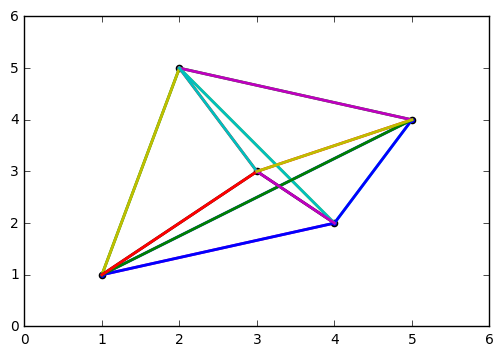

In [194]:
plot(points,make_graph(points),[],[])

When a vertical line is drawn between the points, the connections between the points to the left of the line and right (or top and bottom if horizontal) of the line are broken. When there are no edges in the graph, each point is fully separated from its neighbors. See example below:

First separation


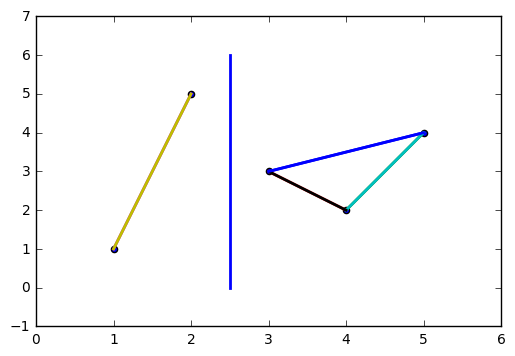

Second separation


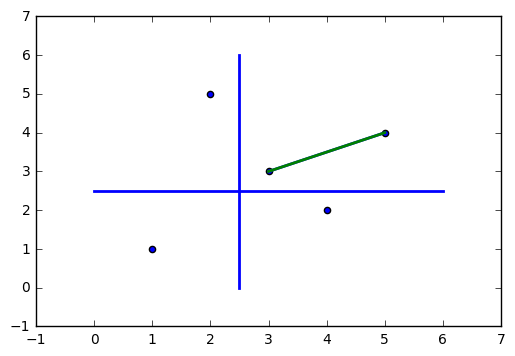

Third separation


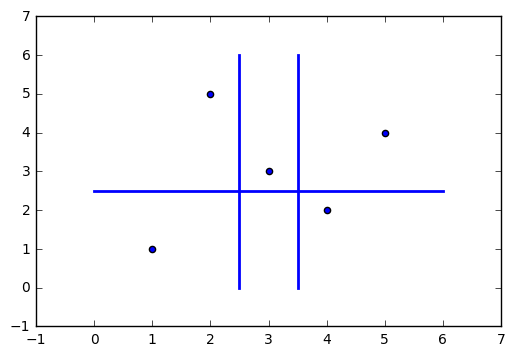

In [195]:
##########################
# Main Program: Separation Example
##########################

print("First separation")
graph = make_graph(points)
draw(graph, 2.5, 0)
plot(points,graph,[2.5],[])

print("Second separation")
draw(graph, 2.5, 1)
plot(points,graph,[2.5],[2.5])

print("Third separation")
draw(graph, 3.5, 0)
plot(points,graph,[2.5,3.5],[2.5])


The professor's paper stated that the optimal number of lines to draw is 2*sqrt(n)-2 (n=number of points). This assumption has been made for the sake of our algorithms.

Our greedy solution algorithm does the following:
1. Gets all vertical lines that can be drawn between the leftmost point and rightmost point and all horizontal lines that can be drawn between the topmost point and bottommost point
2. Initializes the graph representation shown above
3. Calculates the number of lines drawn in an optimal solution
4. While the graph is still connected at any point:
    For every order/combination of horizontal and vertical lines to be drawn:
        draw the line in a copy graph (alternate between vertical and horizontal)
        if more new separations occur than current best, make this line the new best
    Add the best line to the output information
   
   Return all output information

The running time of this algorithm would be O(n^3) with the three loops present.
    The outside while loop iterates through all n nodes in the graph
    The inner for loops together iterate through all possible n^2 edges in the graph

In [196]:
##########################
# Main Program: Greedy Solution
##########################
def find_best(graph, all_lines, lines_drawn, idx):
    best_sep = 0
    best_line = None
    for line in all_lines:
        if line in lines_drawn:
            continue
        else:
            sep = separate(graph, line, idx)
            if sep > best_sep:
                best_line = line
                best_sep = sep
    return best_line, best_sep
            
def segment(points):
    all_x_lines, all_y_lines = get_all_possible(points)
    graph = make_graph(points)
    OPT = math.ceil(math.sqrt(len(points))*2)-2
    
    S = []
    vh = []
    x_lines_drawn = []
    y_lines_drawn = []
    total_lines_drawn = 0
    
    while nodes_left(graph):
        best_line = None
        best_axis = 0
        
        best_line_x, separated_x = find_best(graph, all_x_lines, x_lines_drawn, 0)
        best_line_y, separated_y = find_best(graph, all_y_lines, y_lines_drawn, 1)
        
        if separated_x >= separated_y:
            best_line = best_line_x
            best_axis = 0
        else:
            best_line = best_line_y
            best_axis = 1
        
        if best_axis: 
            y_lines_drawn.append(best_line)
        else: 
            x_lines_drawn.append(best_line)
        
        S.append(best_line)
        vh.append(best_axis)
        total_lines_drawn += 1
        
        graph,sep = draw(graph, best_line, best_axis)

    return (graph,S,vh,total_lines_drawn,x_lines_drawn,y_lines_drawn)

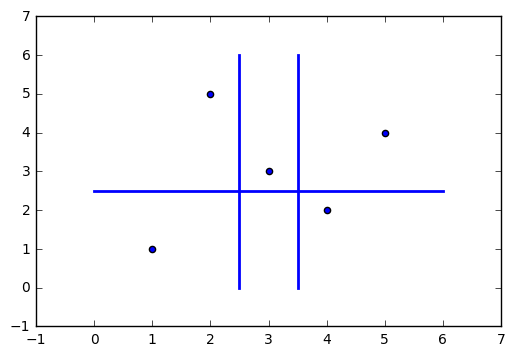

[2.5, 3.5]
[2.5]


In [197]:
# Show final solution
graph,S,vh,total_lines,x_lines,y_lines = segment(points)
plot(points,graph,x_lines,y_lines)
print(x_lines)
print(y_lines)

In [198]:
# Project output
print (total_lines)
for i in range (0,len(S)):
    if (vh[i] == 0):
        print ("v ", S[i])
    elif (vh[i] == 1):
        print ("h ", S[i])

3
v  2.5
h  2.5
v  3.5
